In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', header=None)

movies = movies[[0, 1]]
movies.columns = ['movie_id', 'title']

print("First 5 ratings:\n", ratings.head())
print("\nFirst 5 movies:\n", movies.head())


First 5 ratings:
    user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

First 5 movies:
    movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)


In [3]:
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)

Ratings shape: (100000, 4)
Movies shape: (1682, 2)


In [4]:
rating_matrix = ratings.pivot_table(index='user_id', columns='movie_id', values='rating')
rating_matrix_filled = rating_matrix.fillna(0)

In [5]:
item_similarity = cosine_similarity(rating_matrix_filled.T)
item_sim_df = pd.DataFrame(item_similarity, index=rating_matrix_filled.columns, columns=rating_matrix_filled.columns)

print("Item–Item Similarity matrix created!")

Item–Item Similarity matrix created!


In [6]:
def predict_rating(user, movie, k=5):
    """Predicts rating for a user and a specific movie"""
    if movie not in item_sim_df.columns:
        return ratings['rating'].mean()
    user_ratings = rating_matrix_filled.loc[user]
    similar_movies = item_sim_df[movie].drop(movie).sort_values(ascending=False).head(k)
    top_rated = user_ratings[similar_movies.index]
    numerator = np.dot(similar_movies, top_rated)
    denominator = np.sum(np.abs(similar_movies[top_rated > 0]))
    return numerator / denominator if denominator != 0 else ratings['rating'].mean()

In [7]:
mask = np.random.rand(len(ratings)) < 0.8
train = ratings[mask]
test = ratings[~mask].copy()

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 79958
Test size: 20042


In [8]:
preds = []
for _, row in test.iterrows():
    try:
        preds.append(predict_rating(row['user_id'], row['movie_id']))
    except:
        preds.append(ratings['rating'].mean())

test['pred'] = preds

In [9]:
rmse = mean_squared_error(test['rating'], test['pred']) ** 0.5
mae = mean_absolute_error(test['rating'], test['pred'])

print("Model Evaluation:")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")


Model Evaluation:
RMSE = 1.0330
MAE  = 0.7798


In [16]:
user_id =  np.random.choice(ratings['user_id'])

rated_movies = ratings[ratings['user_id'] == user_id]['movie_id'].tolist()
unseen_movies = list(set(rating_matrix_filled.columns) - set(rated_movies))

predictions = []
for movie in unseen_movies:
    pred_rating = predict_rating(user_id, movie)
    predictions.append((movie, pred_rating))

recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]

print(f"Top 10 Movie Recommendations for User {user_id}:")
for movie_id, score in recommendations:
    title = movies[movies['movie_id'] == movie_id]['title'].values[0]
    print(f"{title} → Predicted Rating: {score:.2f}")


Top 10 Movie Recommendations for User 318:
20,000 Leagues Under the Sea (1954) → Predicted Rating: 5.00
Bridge on the River Kwai, The (1957) → Predicted Rating: 5.00
Rainmaker, The (1997) → Predicted Rating: 5.00
Sunset Blvd. (1950) → Predicted Rating: 5.00
East of Eden (1955) → Predicted Rating: 5.00
It Happened One Night (1934) → Predicted Rating: 5.00
Sophie's Choice (1982) → Predicted Rating: 5.00
Mirage (1995) → Predicted Rating: 5.00
Dead Man Walking (1995) → Predicted Rating: 5.00
Lion King, The (1994) → Predicted Rating: 5.00


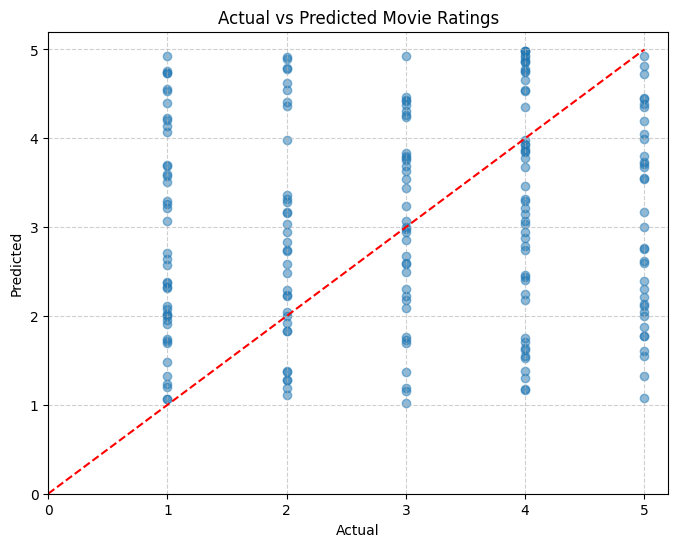

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(test['rating'], test['pred'], alpha=0.5)
plt.plot([0,5], [0,5], 'r--') 
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Movie Ratings")
plt.xlim(0, 5.2)
plt.ylim(0, 5.2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

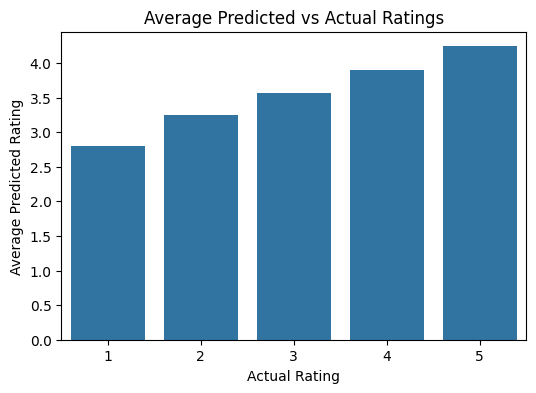

In [22]:
plt.figure(figsize=(6,4))
sns.barplot(data=test, x='rating', y='pred', errorbar=None)
plt.title("Average Predicted vs Actual Ratings")
plt.xlabel("Actual Rating")
plt.ylabel("Average Predicted Rating")
plt.show()


In [35]:
test.to_csv('movie_predictions.csv', index=False)
print(" Predictions saved as 'movie_predictions.csv'")

 Predictions saved as 'movie_predictions.csv'
